# Retail Sales – Hypothesis Testing

This notebook performs statistical hypothesis testing on a retail sales dataset.

We focus on questions such as:

- Do **average order sales differ between customer segments**?
- Is there a **difference in mean sales between two regions**?
- Is there a **relationship between customer segment and region**?

We will use:

- One-way ANOVA
- Two-sample t-test
- Chi-square test of independence


## imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway, ttest_ind, chi2_contingency

%matplotlib inline

pd.set_option("display.max_columns", 50)

## load the CSV

In [2]:
data_path = "../data/raw/train.csv"

df = pd.read_csv(data_path)

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# Keep only relevant columns for this analysis
cols_needed = ["Sales", "Segment", "Region", "Ship Mode"]
df = df[cols_needed].copy()

# Drop rows with missing values in any of these columns (if any)
df = df.dropna(subset=cols_needed)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sales      9800 non-null   float64
 1   Segment    9800 non-null   object 
 2   Region     9800 non-null   object 
 3   Ship Mode  9800 non-null   object 
dtypes: float64(1), object(3)
memory usage: 306.4+ KB


(None,
       Sales    Segment Region       Ship Mode
 0  261.9600   Consumer  South    Second Class
 1  731.9400   Consumer  South    Second Class
 2   14.6200  Corporate   West    Second Class
 3  957.5775   Consumer  South  Standard Class
 4   22.3680   Consumer  South  Standard Class)

## Hypotheses

We will test the following hypotheses:

### 1. ANOVA – Mean Sales by Customer Segment

- **Question:** Is there a significant difference in average order sales between customer segments (Consumer, Corporate, Home Office)?
- **Null hypothesis (H₀):** The mean sales are **equal** across all customer segments.
- **Alternative hypothesis (H₁):** At least one segment has a **different** mean sales compared to the others.

### 2. Two-sample t-test – Mean Sales Between Two Regions

- **Question:** Is there a significant difference in mean sales between the East and West regions?
- **Null hypothesis (H₀):** Mean sales in the East region = mean sales in the West region.
- **Alternative hypothesis (H₁):** Mean sales in the East region ≠ mean sales in the West region.

### 3. Chi-square Test – Relationship Between Segment and Region

- **Question:** Is customer segment independent of region, or is there an association?
- **Null hypothesis (H₀):** Segment and Region are **independent** (no relationship).
- **Alternative hypothesis (H₁):** Segment and Region are **associated** (not independent).


## Test 1: ANOVA (Mean Sales by Segment)

In [4]:
df["Segment"].value_counts()

Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64

In [5]:
df.groupby("Segment")["Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
Segment,,,,,,,,
Consumer,5101.0,225.065777,588.933757,0.444,17.2800,53.982,208.560,13999.96
Corporate,2953.0,233.150720,600.111546,0.556,17.3800,56.300,213.080,17499.95
Home Office,1746.0,243.403309,762.862506,0.990,17.0675,52.560,211.692,22638.48


## Run ANOVA

In [6]:
# Extract Sales values for each segment
consumer_sales = df.loc[df["Segment"] == "Consumer", "Sales"]
corporate_sales = df.loc[df["Segment"] == "Corporate", "Sales"]
homeoffice_sales = df.loc[df["Segment"] == "Home Office", "Sales"]

# One-way ANOVA
f_stat, p_value = f_oneway(consumer_sales, corporate_sales, homeoffice_sales)

print("ANOVA – Mean Sales by Segment")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value:     {p_value:.6f}")

ANOVA – Mean Sales by Segment
F-statistic: 0.5874
p-value:     0.555788


## Brief interpretation

In [7]:
alpha = 0.05  # significance level

if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < {alpha}, we **reject H0**.")
    print("Conclusion: There is a statistically significant difference in mean sales between at least two customer segments.")
else:
    print(f"Since p-value ({p_value:.6f}) >= {alpha}, we **fail to reject H0**.")
    print("Conclusion: We do NOT have evidence of a significant difference in mean sales between segments.")

Since p-value (0.555788) >= 0.05, we **fail to reject H0**.
Conclusion: We do NOT have evidence of a significant difference in mean sales between segments.


## Test 2: Two-sample t-test (East vs West)

In [8]:
df["Region"].value_counts()

Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

## Extract East vs West sales

In [9]:
east_sales = df.loc[df["Region"] == "East", "Sales"]
west_sales = df.loc[df["Region"] == "West", "Sales"]

print("East sample size:", east_sales.shape[0])
print("West sample size:", west_sales.shape[0])

east_sales.describe(), west_sales.describe()

East sample size: 2785
West sample size: 3140


(count     2785.000000
 mean       240.401697
 std        626.366105
 min          0.852000
 25%         17.712000
 50%         54.960000
 75%        211.960000
 max      11199.968000
 Name: Sales, dtype: float64,
 count     3140.000000
 mean       226.184613
 std        524.240789
 min          0.990000
 25%         19.440000
 50%         61.002000
 75%        215.606500
 max      13999.960000
 Name: Sales, dtype: float64)

## Run Welch’s t-test (safer than assuming equal variance)

In [10]:
t_stat, p_val_ttest = ttest_ind(east_sales, west_sales, equal_var=False)

print("Two-sample t-test (Welch) – Mean Sales: East vs West")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value:     {p_val_ttest:.6f}")

Two-sample t-test (Welch) – Mean Sales: East vs West
t-statistic: 0.9407
p-value:     0.346887


## Interpretation

In [11]:
alpha = 0.05

if p_val_ttest < alpha:
    print(f"Since p-value ({p_val_ttest:.6f}) < {alpha}, we **reject H0**.")
    print("Conclusion: Mean sales differ significantly between East and West regions.")
else:
    print(f"Since p-value ({p_val_ttest:.6f}) >= {alpha}, we **fail to reject H0**.")
    print("Conclusion: No statistically significant difference in mean sales between East and West.")

Since p-value (0.346887) >= 0.05, we **fail to reject H0**.
Conclusion: No statistically significant difference in mean sales between East and West.


## Visual comparison plot

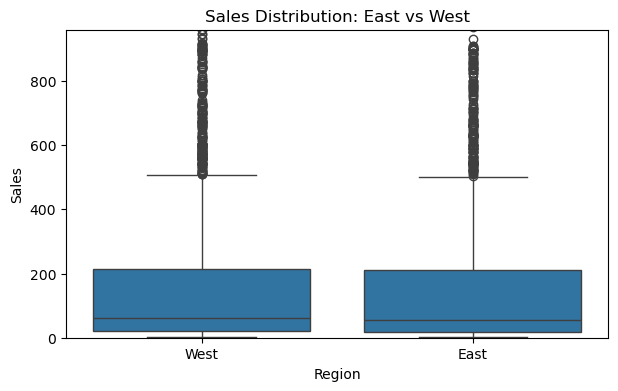

In [12]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df[df["Region"].isin(["East", "West"])], x="Region", y="Sales")
plt.title("Sales Distribution: East vs West")
plt.ylim(0, df["Sales"].quantile(0.95))  # trims extreme outliers for readability
plt.show()

## Test 3: Chi-square test (Segment vs Region)

### Build contingency table

In [13]:
contingency_table = pd.crosstab(df["Segment"], df["Region"])
contingency_table

Region,Central,East,South,West
Segment,,,,
Consumer,1188,1444,831,1638
Corporate,661,850,500,942
Home Office,428,491,267,560


### Run chi-square test of independence

In [14]:
chi2, p_val_chi, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test – Segment vs Region")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom:   {dof}")
print(f"p-value:              {p_val_chi:.6f}")

Chi-square Test – Segment vs Region
Chi-square statistic: 4.2075
Degrees of freedom:   6
p-value:              0.648616


### Interpretation

In [15]:
alpha = 0.05

if p_val_chi < alpha:
    print(f"Since p-value ({p_val_chi:.6f}) < {alpha}, we **reject H0**.")
    print("Conclusion: Segment and Region are associated (not independent).")
else:
    print(f"Since p-value ({p_val_chi:.6f}) >= {alpha}, we **fail to reject H0**.")
    print("Conclusion: No evidence of association; Segment and Region appear independent.")

Since p-value (0.648616) >= 0.05, we **fail to reject H0**.
Conclusion: No evidence of association; Segment and Region appear independent.


### Heatmap of counts

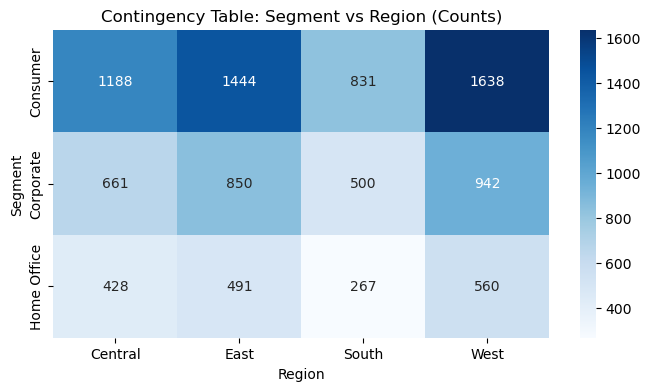

In [16]:
plt.figure(figsize=(8, 4))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues")
plt.title("Contingency Table: Segment vs Region (Counts)")
plt.xlabel("Region")
plt.ylabel("Segment")
plt.show()

## Conclusions

### ANOVA (Sales by Segment)
- Result: `Insert your p-value`  
- Interpretation: `Reject / Fail to reject H0`
- Meaning: `Explain in 1 line`

### t-test (Sales East vs West)
- Result: `Insert your p-value`
- Interpretation: `Reject / Fail to reject H0`
- Meaning: `Explain in 1 line`

### Chi-square (Segment vs Region)
- Result: `Insert your p-value`
- Interpretation: `Reject / Fail to reject H0`
- Meaning: `Explain in 1 line`

**Summary:**  
This project demonstrates the use of hypothesis testing on a real retail dataset, applying ANOVA, t-test, and chi-square to answer business-relevant questions.
